# 1. Reading and Understanding the Data

In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

### Helper Functions

In [3]:
def plot(y_true, y_prediction):
    plt.plot(y_true, color='red', label='Actual Stock Prices')
    plt.plot(y_prediction, color='blue', label='Predicted Stock Prices')
    plt.title(str.capitalize(key))
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

### Reading the Data

In [4]:
dataset = pd.read_csv("../all_stocks_2006-01-01_to_2018-01-01.csv", index_col="Date")

In [5]:
print(dataset.shape)

(93612, 6)


In [6]:
print(dataset.Name.unique())

['MMM' 'AXP' 'AAPL' 'BA' 'CAT' 'CVX' 'CSCO' 'KO' 'DIS' 'XOM' 'GE' 'GS'
 'HD' 'IBM' 'INTC' 'JNJ' 'JPM' 'MCD' 'MRK' 'MSFT' 'NKE' 'PFE' 'PG' 'TRV'
 'UTX' 'UNH' 'VZ' 'WMT' 'GOOGL' 'AMZN' 'AABA']


There are lots of companies in the dataset. I will just analyze five of them: Microsoft, Google, Apple, Amazon, Ibm.

In [7]:
microsoft = dataset[dataset['Name']=='MSFT']
google = dataset[dataset['Name']=='GOOGL']
apple = dataset[dataset['Name']=='AAPL']
amazon = dataset[dataset['Name']=='AMZN']
ibm = dataset[dataset['Name']=='IBM']

# 2. Data Preprocessing 

In [8]:
print(dataset.duplicated().sum())

0


There aren't any duplicated values in the dataset.

In [9]:
stocks = [microsoft, google, apple, amazon, ibm]
for i in stocks:
    print('\033[1mNULL VALUES\033[0m\n'+ str(i.isnull().sum()))

NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64
NULL VALUES
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64


There are some null values in ibm dataset. I will use ffill method. ‘ffill’ stands for ‘forward fill’ and will propagate last valid observation forward. In this way, last stock value will fill the null value.

In [10]:
ibm.fillna(method='ffill', inplace=True)

In [11]:
print(ibm.isnull().sum().any())

False


# 3. Exploratory Data Analysis

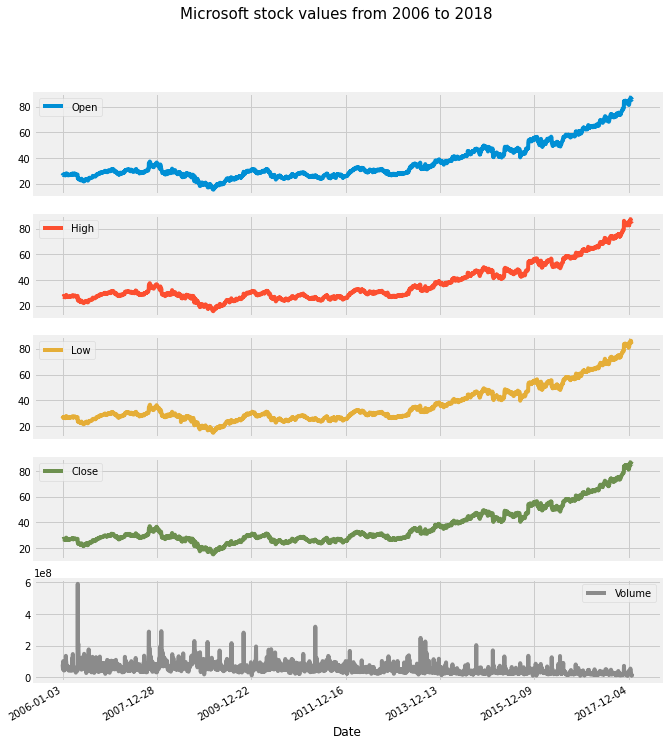

In [12]:
microsoft.plot(subplots=True, figsize=(10,12))
plt.suptitle('Microsoft stock values from 2006 to 2018', fontsize=15)
plt.show()

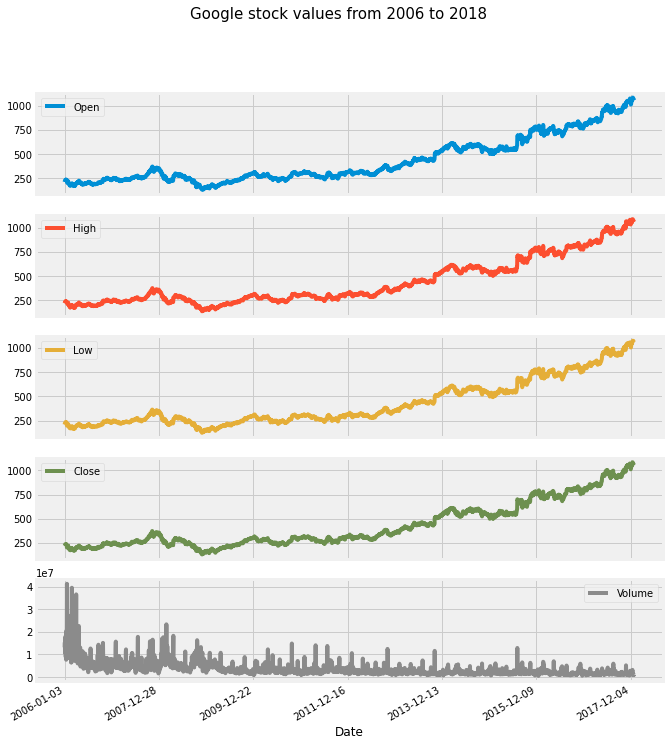

In [13]:
google.plot(subplots=True, figsize=(10,12))
plt.suptitle('Google stock values from 2006 to 2018', fontsize=15)
plt.show()

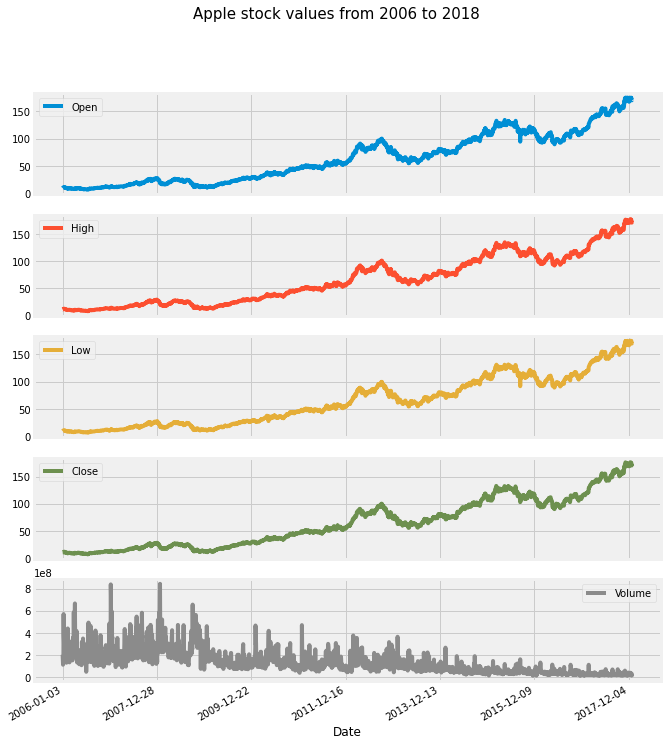

In [14]:
apple.plot(subplots=True, figsize=(10,12))
plt.suptitle('Apple stock values from 2006 to 2018', fontsize=15)
plt.show()

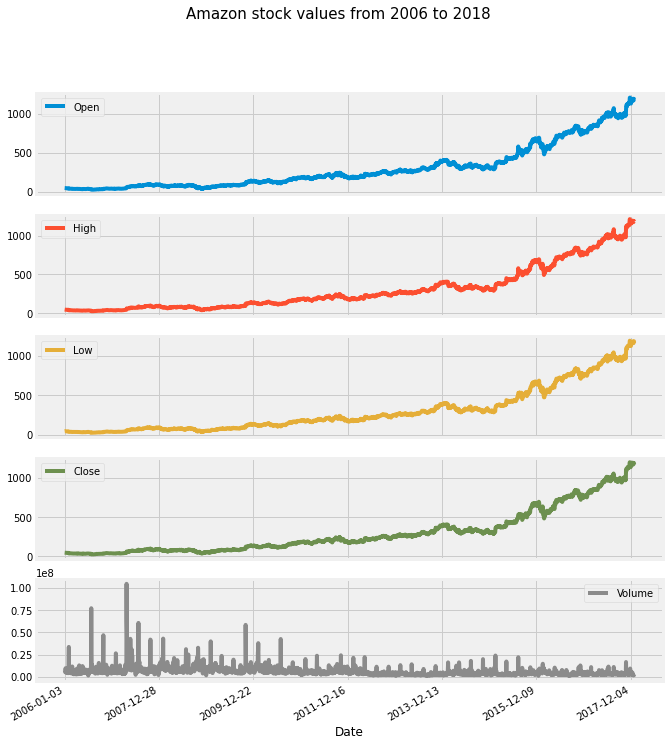

In [15]:
amazon.plot(subplots=True, figsize=(10,12))
plt.suptitle('Amazon stock values from 2006 to 2018', fontsize=15)
plt.show()

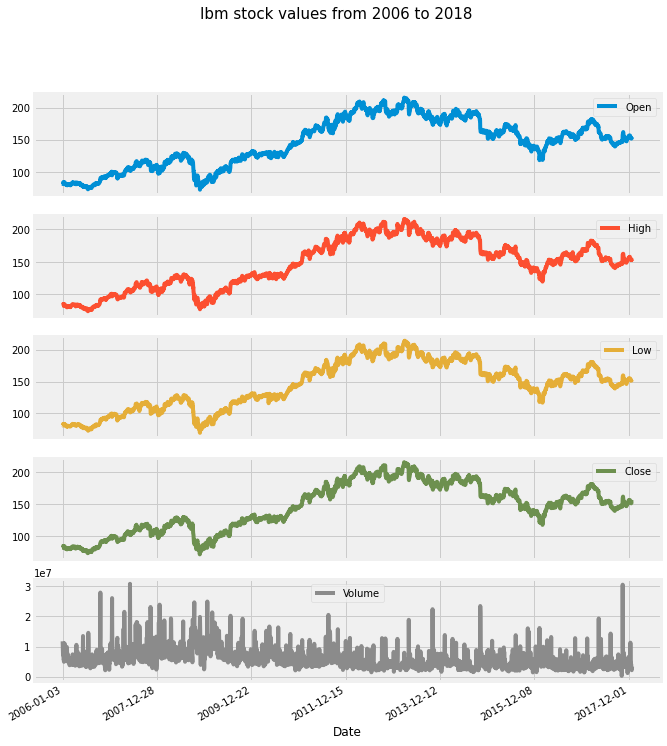

In [16]:
ibm.plot(subplots=True, figsize=(10,12))
plt.suptitle('Ibm stock values from 2006 to 2018', fontsize=15)
plt.show()

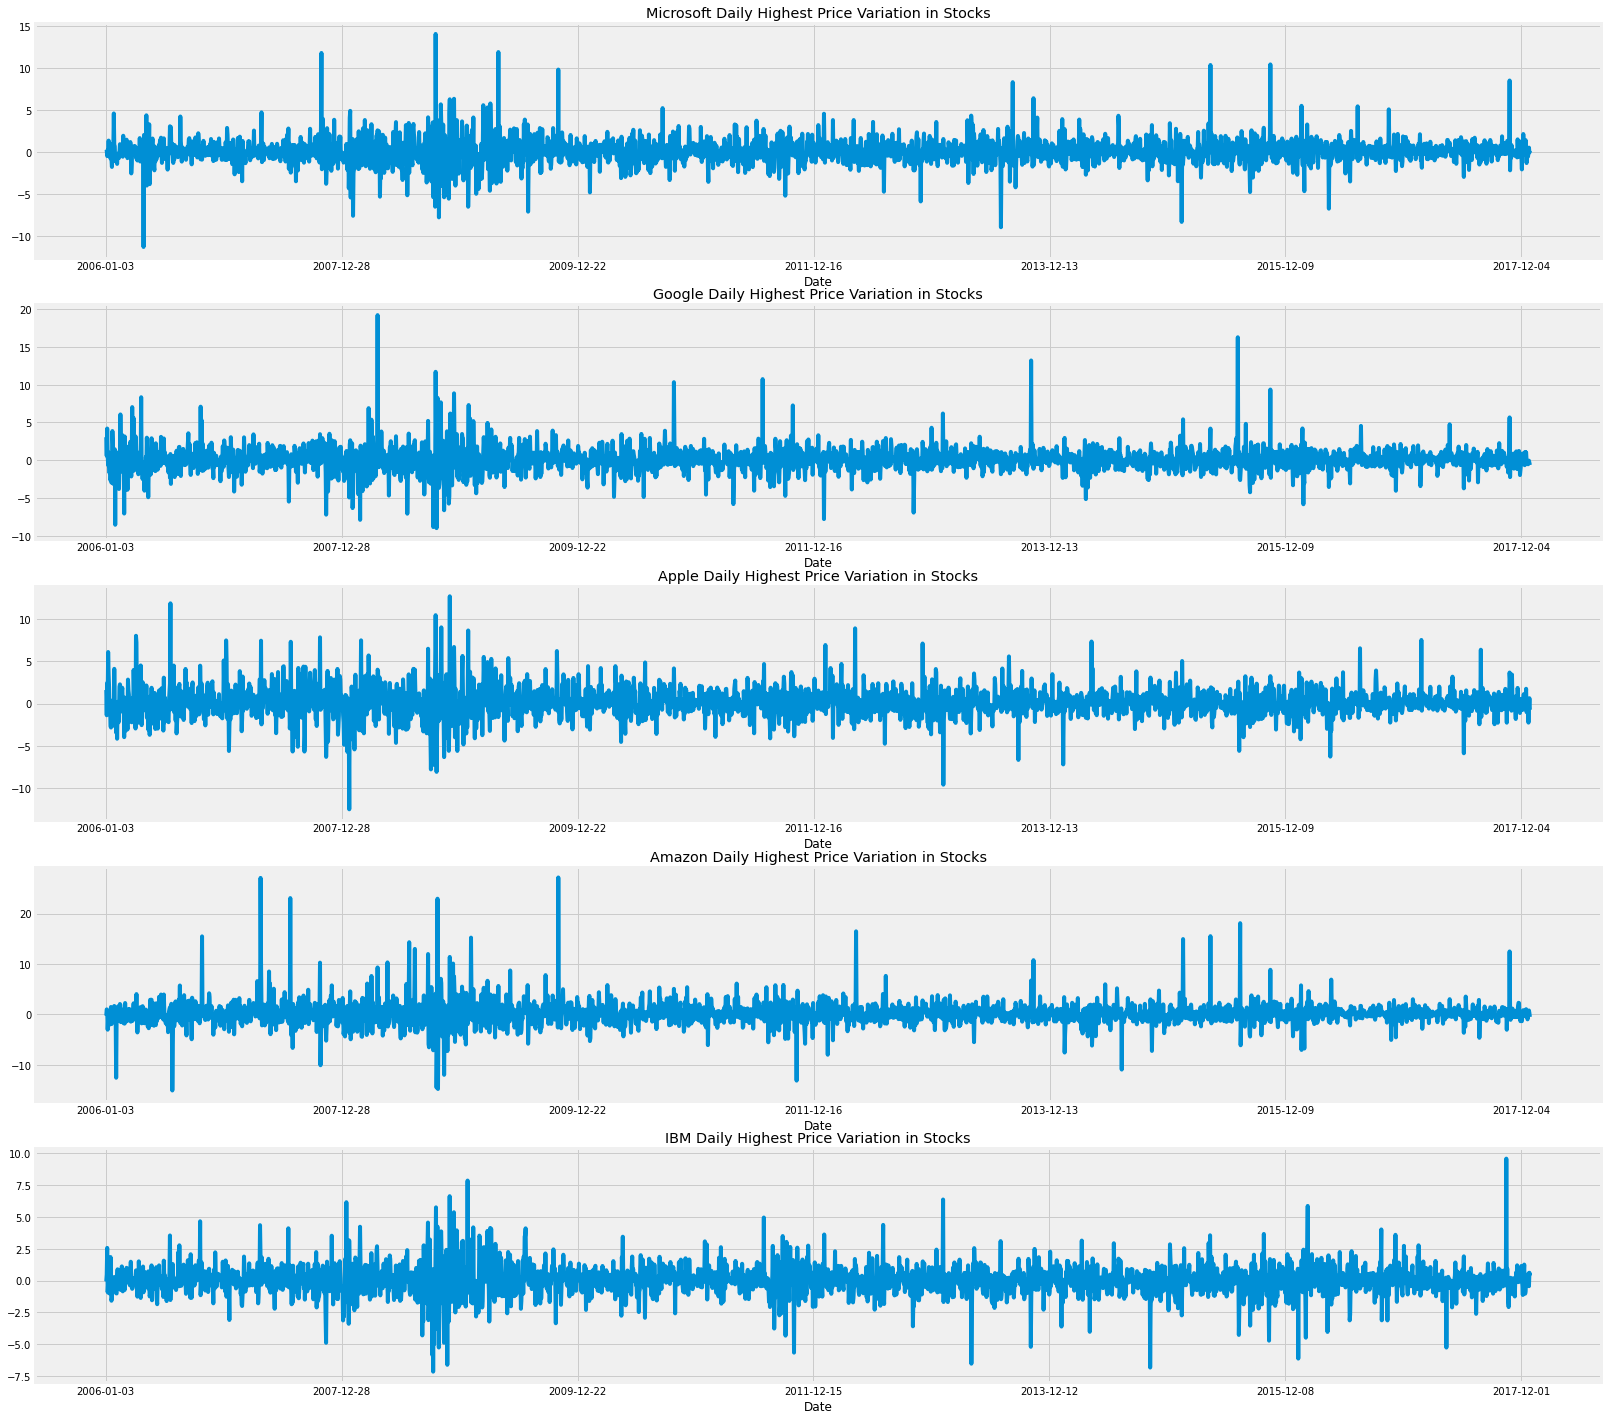

In [17]:
plt.figure(figsize=(25,25))

plt.subplot(5,1,1)
microsoft.High.pct_change().mul(100).plot()
plt.title("Microsoft Daily Highest Price Variation in Stocks")

plt.subplot(5,1,2)
google.High.pct_change().mul(100).plot()
plt.title("Google Daily Highest Price Variation in Stocks")

plt.subplot(5,1,3)
apple.High.pct_change().mul(100).plot()
plt.title("Apple Daily Highest Price Variation in Stocks")

plt.subplot(5,1,4)
amazon.High.pct_change().mul(100).plot()
plt.title("Amazon Daily Highest Price Variation in Stocks")

plt.subplot(5,1,5)
ibm.High.pct_change().mul(100).plot()
plt.title("IBM Daily Highest Price Variation in Stocks")

plt.show()

The graph above show the price variation in stocks for all the companies comparing the price values for two consequtive days. There are high price changes during 2008 financial crisis period.

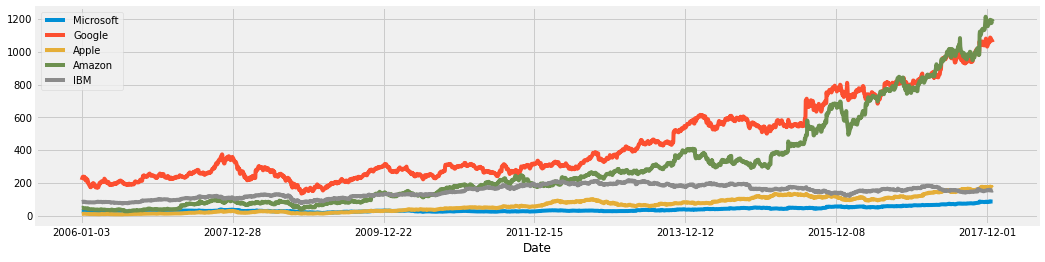

In [18]:
microsoft["High"].plot(figsize=(16,4),legend=True)
google["High"].plot(figsize=(16,4),legend=True)
apple["High"].plot(figsize=(16,4),legend=True)
amazon["High"].plot(figsize=(16,4),legend=True)
ibm["High"].plot(figsize=(16,4),legend=True)
plt.legend(['Microsoft','Google', 'Apple', 'Amazon', 'IBM'])
plt.show()

Google and Amazon's stock prices are significantly higher than Apple, IBM, and Microsoft.

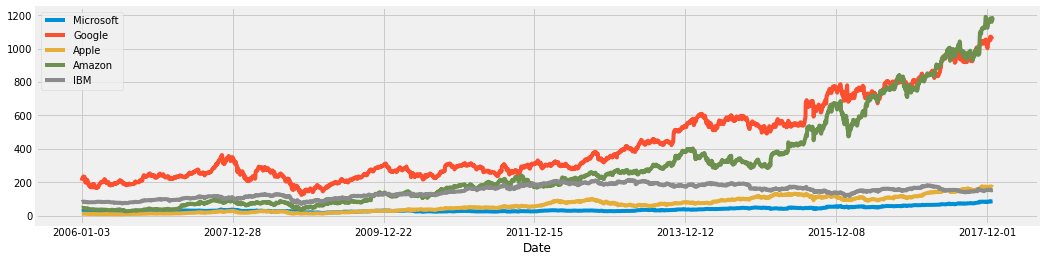

In [19]:
microsoft["Low"].plot(figsize=(16,4),legend=True)
google["Low"].plot(figsize=(16,4),legend=True)
apple["Low"].plot(figsize=(16,4),legend=True)
amazon["Low"].plot(figsize=(16,4),legend=True)
ibm["Low"].plot(figsize=(16,4),legend=True)
plt.legend(['Microsoft','Google', 'Apple', 'Amazon', 'IBM'])
plt.show()

# 4. Data Preparation

### Splitting the Dataset

We will split the dataset as train and test sets. Train set include the period that shows the highest stock prices until 2016. Test set include the period starting from 2016 and ends in 2018.

In [20]:
def split(data):
    return data[:'2016'].iloc[:, 1:2].values, data['2016':].iloc[:,1:2].values

microsoft_train, microsoft_test = split(microsoft)
google_train, google_test = split(google)
apple_train, apple_test = split(apple)
amazon_train, amazon_test = split(amazon)
ibm_train, ibm_test = split(ibm)

In [21]:
print("\033[1mShapes of train and test sets\033[0m\n")
print("Microsoft train set:", microsoft_train.shape, "Microsoft test set:", microsoft_test.shape)
print("Google train set:", google_train.shape, "Google test set:", google_test.shape)
print("Apple train set:", apple_train.shape, "Apple test set:", apple_test.shape)
print("Amazon train set:", amazon_train.shape, "Amazon test set:", amazon_test.shape)
print("IBM train set:", ibm_train.shape, "IBM test set:", ibm_test.shape)

Shapes of train and test sets

Microsoft train set: (2516, 1) Microsoft test set: (503, 1)
Google train set: (2516, 1) Google test set: (503, 1)
Apple train set: (2516, 1) Apple test set: (503, 1)
Amazon train set: (2516, 1) Amazon test set: (503, 1)
IBM train set: (2517, 1) IBM test set: (503, 1)


### Scaling the Data

We have to scale our data for optimal performance. When evaluating stock prices, we’ll use Scikit-Learn’s MinMaxScaler and scale our dataset to numbers between zero and one.

In [22]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
microsoft_train_scaled, microsoft_test_scaled = sc.fit_transform(microsoft_train), sc.fit_transform(microsoft_test)
google_train_scaled, google_test_scaled = sc.fit_transform(google_train), sc.fit_transform(google_test)
apple_train_scaled, apple_test_scaled = sc.fit_transform(apple_train), sc.fit_transform(apple_test)
amazon_train_scaled, amazon_test_scaled = sc.fit_transform(amazon_train), sc.fit_transform(amazon_test)
ibm_train_scaled, ibm_test_scaled = sc.fit_transform(ibm_train), sc.fit_transform(ibm_test)

### Training with LSTM

We will apply "Many to One" LSTM model. We will create a structure that contains 60 timesteps and 1 output. 

The model expect the data to be in the shape "samples, timesteps, features". That's why we change the shape of training set.

In [23]:
train_map = {"microsoft": microsoft_train_scaled, "google": google_train_scaled, "apple": apple_train_scaled, "amazon": amazon_train_scaled, "ibm": ibm_train_scaled}
train_map_X = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}
train_map_y = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}

for key in train_map.keys():
    for i in range(60,2516):   
        train_map_X[key].append(train_map[key][i-60:i,0])
        train_map_y[key].append(train_map[key][i, 0])
    train_map_X[key], train_map_y[key] = np.array(train_map_X[key]), np.array(train_map_y[key])
    train_map_X[key] = np.reshape(train_map_X[key], (train_map_X[key].shape[0],train_map_X[key].shape[1],1))

In [25]:
for key in train_map_X.keys():
    
    # The LSTM architecture
    lstm = Sequential()

    # First LSTM layer with Dropout regularisation
    lstm.add(LSTM(units=50, return_sequences=True, input_shape=(train_map_X[key].shape[1],1)))
    lstm.add(Dropout(0.2))

    # Second LSTM layer
    lstm.add(LSTM(units=50, return_sequences=True))
    lstm.add(Dropout(0.2))

    # Third LSTM layer
    lstm.add(LSTM(units=50, return_sequences=True))
    lstm.add(Dropout(0.2))

    # Fourth LSTM layer
    lstm.add(LSTM(units=50))
    lstm.add(Dropout(0.2))

    # The output layer
    lstm.add(Dense(units=1))

    # Compiling the RNN
    lstm.compile(optimizer='rmsprop',loss='mean_squared_error')
    
    # Fitting to the training set
    print("Training:", key)
    lstm.fit(train_map_X[key],train_map_y[key],epochs=20,batch_size=32)


Training: microsoft
Epoch 1/20
2456/2456 [==============================] - 9s 4ms/step - loss: 0.0174
Epoch 2/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0072
Epoch 3/20
2456/2456 [==============================] - 8s 3ms/step - loss: 0.0058
Epoch 4/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0049
Epoch 5/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0036
Epoch 6/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0037
Epoch 7/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0033
Epoch 8/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0034
Epoch 9/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0026
Epoch 10/20
2456/2456 [==============================] - 8s 3ms/step - loss: 0.0026
Epoch 11/20
2456/2456 [==============================] - 7s 3ms/step - loss: 0.0023
Epoch 12/20
2456/2456 [==============================] - 8s 3ms/s

In [27]:
test_map = {"microsoft": microsoft_test_scaled, "google": google_test_scaled, "apple": apple_test_scaled, "amazon": amazon_test_scaled, "ibm": ibm_test_scaled}
test_map_X = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}
test_map_y = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}

for key in test_map.keys():
    for i in range(60,503):
        test_map_X[key].append(test_map[key][i-60:i,0])
        test_map_y[key].append(test_map[key][i, 0])
    test_map_X[key], test_map_y[key]= np.array(test_map_X[key]), np.array(test_map_y[key])
    test_map_X[key] = np.reshape(test_map_X[key], (test_map_X[key].shape[0], test_map_X[key].shape[1], 1))

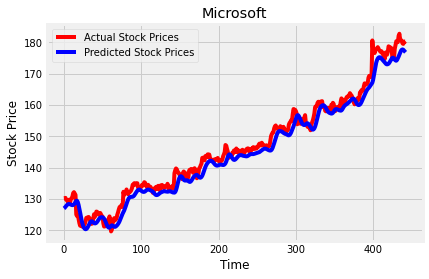

Microsoft Root Mean Squared Error: 2.796989217948212


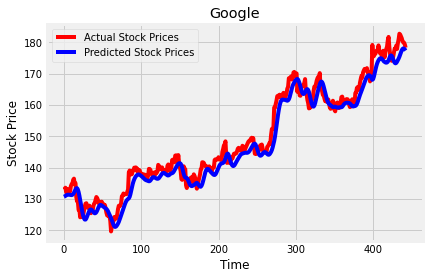

Google Root Mean Squared Error: 3.27884841129987


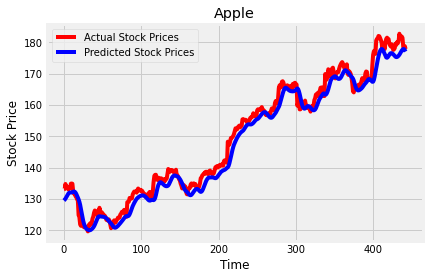

Apple Root Mean Squared Error: 2.9603769269445435


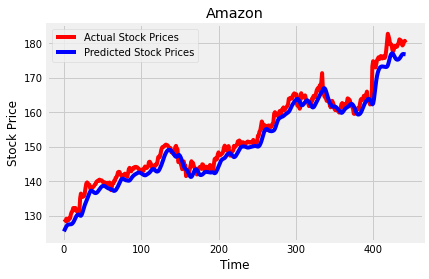

Amazon Root Mean Squared Error: 2.6933983398741317


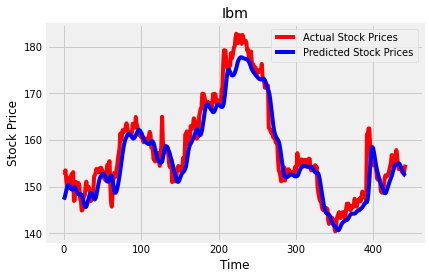

Ibm Root Mean Squared Error: 3.195672756410282


In [28]:
for key in test_map_X.keys():
    y_true = sc.inverse_transform(test_map_y[key].reshape(-1,1)) 
    y_prediction = sc.inverse_transform(lstm.predict(test_map_X[key]))   
    plot(y_true, y_prediction)
    rmse = sqrt(mean_squared_error(y_true, y_prediction))
    print(str.capitalize(key), "Root Mean Squared Error:", rmse)

### Training with GRU

GRU is computationally easier than LSTM since it has only 2 gates. GRU use less training parameters and therefore use less memory, execute faster and train faster than LSTM's whereas LSTM is more accurate on dataset using longer sequence.  In short, if sequence is large or accuracy is very critical, LSTM is better whereas for less memory consumption and faster operation GRU is better.

In [29]:
for key in train_map_X.keys():
    
    # The GRU architecture
    gru = Sequential()
    
    # First GRU layer with Dropout regularisation

    gru.add(GRU(units=50, return_sequences=True, input_shape=(train_map_X[key].shape[1],1), activation='tanh'))
    gru.add(Dropout(0.2))
    
    # Second GRU layer
    gru.add(GRU(units=50, return_sequences=True, input_shape=(train_map_X[key].shape[1],1), activation='tanh'))
    gru.add(Dropout(0.2))
    
    # Third GRU layer
    gru.add(GRU(units=50, return_sequences=True, input_shape=(train_map_X[key].shape[1],1), activation='tanh'))
    gru.add(Dropout(0.2))
    
    # Fourth GRU layer
    gru.add(GRU(units=50, activation='tanh'))
    gru.add(Dropout(0.2))
    
    # The output layer
    gru.add(Dense(units=1))
    
    # Compiling the RNN
    gru.compile(optimizer=SGD(), loss='mean_squared_error')
    
    # Fitting to the training set
    print("Training:", key)
    gru.fit(train_map_X[key], train_map_y[key], epochs=20, batch_size=150)

Training: microsoft
Epoch 1/20
2456/2456 [==============================] - 6s 2ms/step - loss: 0.0707
Epoch 2/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0321
Epoch 3/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0304
Epoch 4/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0296
Epoch 5/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0289
Epoch 6/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0271
Epoch 7/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0255
Epoch 8/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0250
Epoch 9/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0229
Epoch 10/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0219
Epoch 11/20
2456/2456 [==============================] - 4s 2ms/step - loss: 0.0206
Epoch 12/20
2456/2456 [==============================] - 4s 2ms/s

In [30]:
test_map = {"microsoft": microsoft_test_scaled, "google": google_test_scaled, "apple": apple_test_scaled, "amazon": amazon_test_scaled, "ibm": ibm_test_scaled}
test_map_X = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}
test_map_y = {"microsoft": [], "google": [], "apple": [], "amazon": [], "ibm": []}

for key in test_map.keys():
    for i in range(60,503):
        test_map_X[key].append(test_map[key][i-60:i,0])
        test_map_y[key].append(test_map[key][i, 0])
    test_map_X[key], test_map_y[key]= np.array(test_map_X[key]),  np.array(test_map_y[key])
    test_map_X[key] = np.reshape(test_map_X[key], (test_map_X[key].shape[0],test_map_X[key].shape[1],1))

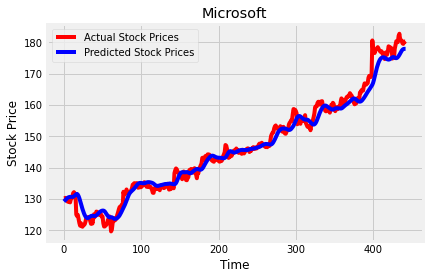

Microsoft Root Mean Squared Error: 2.5544414879939863


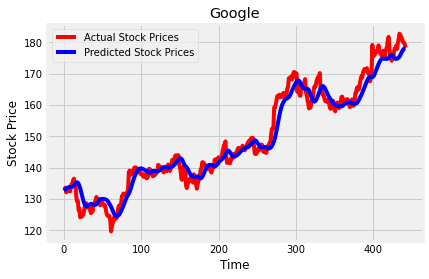

Google Root Mean Squared Error: 3.2548395184203978


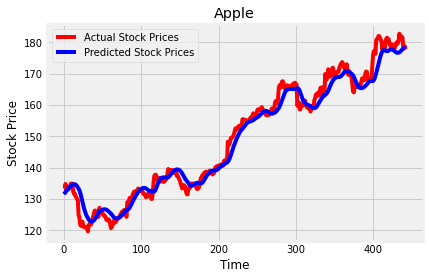

Apple Root Mean Squared Error: 2.9688617196928218


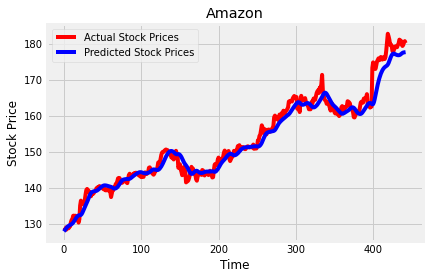

Amazon Root Mean Squared Error: 2.3254694959132625


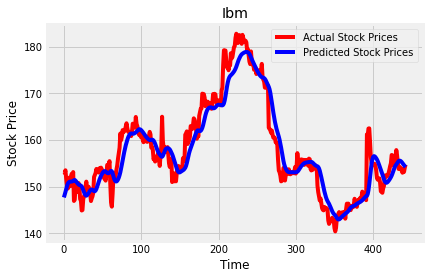

Ibm Root Mean Squared Error: 3.3312461424939426


In [31]:
for key in test_map_X.keys():
    y_true = sc.inverse_transform(test_map_y[key].reshape(-1,1)) 
    y_prediction = sc.inverse_transform(gru.predict(test_map_X[key]))   
    plot(y_true, y_prediction)
    rmse = sqrt(mean_squared_error(y_true, y_prediction))
    print(str.capitalize(key), "Root Mean Squared Error:", rmse)